# Introduction

Please read the measure risk explanation section in the readme before continuing.

When I ran this program the first few times, I wanted to compare the average number of risk occurrences found for each firm. This measure represents the sum of all risk occurrences of all risk measures, divided by the number of firms. I noticed that those from the 21 firms which were analyzed by their entire 10K were much higher than those from just the risk section. This can most likely be blamed on the much higher word count for scanning through an entire 10K, and would naturally result in more occurences. In order to combat this and try to level the playing field between the 2 styles of finding risk measures, I decreased the maximum number of words apart when scanning a 10K from 100 (the default for the risk section) to 20, the average length of words in a sentence. This made the two averages more comparable. The following are average risk occurrences for each file for different numbers of max_words when scanning entire 10Ks:
- 100 Words: 14.928 risks per firm 
- 50 Words: 12.294 risks per firm 
- 20 Words: 8.84 risks per firm 


These values can be compared to the average number of occurrences of 3.745467 when scanning the risk section. Although this number is still significantly lower than the number of risks found when scanning the 10K with a maximum of 20 words, due to the much larger overall wordcount, I thought this discrepancy was to be expected. It's also interesting to note that a 50% decrease in max words does not correspond to a 50% decrease in the risks found. 

The following cells display graphical and statistical data related to each risk measure, as well as the dataset as a whole.

In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from datetime import datetime 

In [2]:
#lets load the data 
form10K_df = pd.read_csv('outputs/form10K_risks.csv')
#same issue with loading csvs 
if 'Unnamed: 0' in form10K_df:
    del form10K_df['Unnamed: 0']

In [3]:
#lets begin the analysis
#as discussed above, lets see how many firms were analyzed using the entire 10K, and those that just had the risk section
print('Risk Sections Found: %d' % len(form10K_df[form10K_df['doctype'] == 'Risk Section']))
print('Risk Sections Not Found: %d' % len(form10K_df[form10K_df['doctype'] == '10K']))

Risk Sections Found: 478
Risk Sections Not Found: 21


In [4]:
#what firms don't have the usually labeled risk section in the 10K?
for index, row in form10K_df.iterrows():
    if row['doctype'] == '10K':
        print(row['tic'])

AMGN
CAH
C
CLX
EIX
FDX
GE
HAL
HPQ
INTC
ICE
MCD
MS
NLOK
ROL
STX
SWKS
SYF
TMO
USB
WFC


In [5]:
#describe each of the risk variables discussed above
risk_names = ['supply_chain_risk', 'regulatory_risk', 'inflationary_risk', 'macro_risk', 'debt_risk', 'liquidity_risk']
form10K_df[risk_names].describe()

,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,3.098196,8.364729,0.503006,5.713427,3.585170,2.494990
std,3.412177,11.960076,1.153609,8.409932,5.980412,5.889671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
50%,2.000000,5.000000,0.000000,4.000000,2.000000,1.000000
75%,5.000000,10.000000,1.000000,7.000000,4.000000,2.000000
max,19.000000,148.000000,11.000000,103.000000,65.000000,76.000000


In [6]:
#and lets see if theres a large difference between the number of risks observed when considering only the risk section vs the entire 10K
risk_q = form10K_df.query('doctype in ["Risk Section"]')
risk_q.describe()

,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk
count,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000
mean,3.146444,8.048117,0.502092,5.194561,3.382845,2.198745
std,3.417721,11.056544,1.150606,5.671087,5.473577,4.463248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
50%,2.000000,5.000000,0.000000,4.000000,2.000000,1.000000
75%,5.000000,10.000000,1.000000,7.000000,4.000000,2.000000
max,19.000000,148.000000,11.000000,62.000000,65.000000,44.000000


In [7]:
#the sample size for sampling the entire 10K is pretty small, but this should give us some idea how this affects results
form10K_q = form10K_df.query('doctype in ["10K"]')
form10K_q.describe()

,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,2.000000,15.571429,0.523810,17.523810,8.190476,9.238095
std,3.162278,24.274619,1.249762,29.002791,12.359689,18.406262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000,7.000000,4.000000,2.000000
75%,3.000000,8.000000,0.000000,14.000000,8.000000,6.000000
max,13.000000,70.000000,5.000000,103.000000,54.000000,76.000000


In [8]:
#interesting to note than the mean of supply chain risks found actually decreases when looking at the entire 10K. all the others increase as expected 
#as discussed in the commentary header, this cell determines the number of risks found in firms analyzed by risk section, and by the entire 10K
mean_risk = []
mean_10K = []
sd_risk = []
sd_10K = []
for name in risk_names:
    mean_risk.append(risk_q[name].mean())
    mean_10K.append(form10K_q[name].mean())
    sd_risk.append(risk_q[name].std())
    sd_10K.append(form10K_q[name].std())
avg_obs_risk = sum(mean_risk) / len(mean_risk)
avg_obs_10K = sum(mean_10K) / len(mean_10K)
print('Mean Observations per Measure from Risk Section: %f' % avg_obs_risk)
print('Mean Observations per Measure from 10K: %f' % avg_obs_10K)

Mean Observations per Measure from Risk Section: 3.745467
Mean Observations per Measure from 10K: 8.841270


In [9]:
#are there any firms with no occurrences for any risk measure?
zero_firms = []
for index, row in form10K_df.iterrows():
    risk_sum = 0
    for name in risk_names:
        risk_sum += row[name]
    if risk_sum == 0:
        zero_firms.append(row['tic'])
print('%d firms have no risk measures.' % len(zero_firms))
print(zero_firms)

69 firms have no risk measures.
['AES', 'AKAM', 'ARE', 'AEE', 'AMGN', 'ANSS', 'AAPL', 'AVB', 'BK', 'BIO', 'KMX', 'CCL', 'CE', 'CHTR', 'CTXS', 'CMS', 'CMCSA', 'STZ', 'DHR', 'DRI', 'DXCM', 'FANG', 'EMN', 'EVRG', 'EXPD', 'EXR', 'FDX', 'FTV', 'BEN', 'GRMN', 'GNRC', 'GILD', 'HPE', 'HOLX', 'HBAN', 'IP', 'JBHT', 'KEYS', 'LYB', 'MRO', 'MPC', 'MXIM', 'MTD', 'MCHP', 'MSI', 'NI', 'NCLH', 'NRG', 'NVDA', 'ORLY', 'PYPL', 'PFE', 'DGX', 'SWKS', 'SO', 'TTWO', 'TDY', 'TSLA', 'TWTR', 'TYL', 'UPS', 'UNM', 'VTR', 'WBA', 'WU', 'WY', 'WMB', 'WLTW', 'ZION']


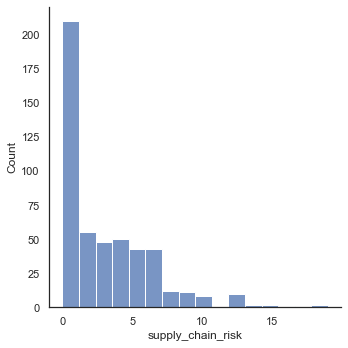

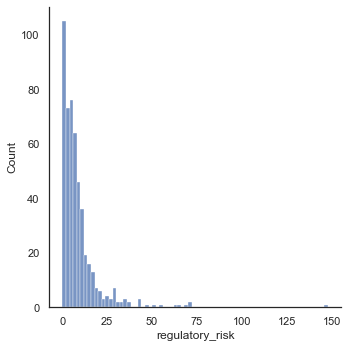

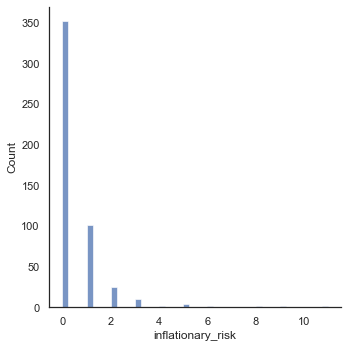

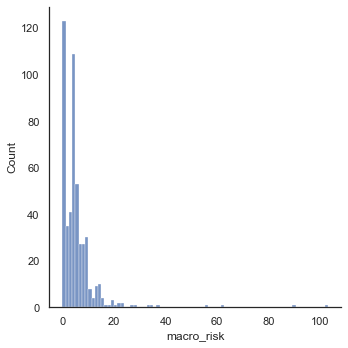

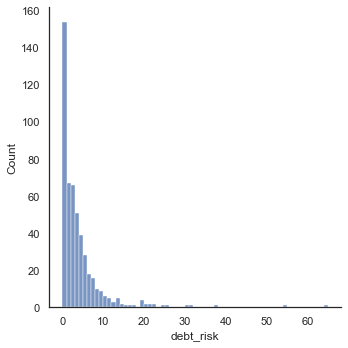

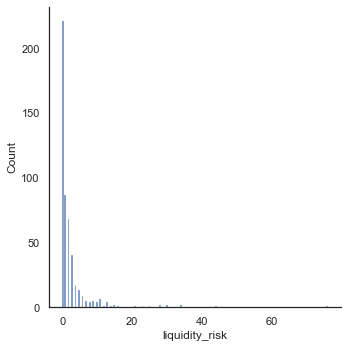

In [10]:
#quite a few, lets see if it skews the data
sns.set_theme(style="white")
for name in risk_names[:6]:
    sns.displot(form10K_df[name])

[Text(0.5, 0, 'count'), Text(0, 0.5, 'risk')]

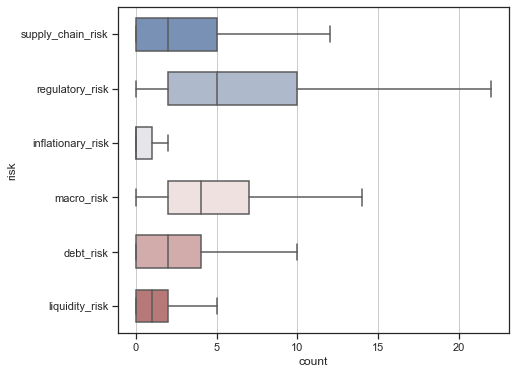

In [11]:
#it does a bit, but thats to be somewhat expected
#lets get a better look at each variable, first without outliers 
sns.set_theme(style='ticks')
f, ax = plt.subplots(figsize=(7,6))

sns.boxplot(y='variable', x = 'value', data= pd.melt(form10K_df.filter(like='_risk')), width = 0.6, palette='vlag', showfliers=False)
ax.xaxis.grid(True)
ax.set(xlabel= 'count', ylabel='risk')

[Text(0.5, 17.200000000000003, 'count'), Text(17.200000000000003, 0.5, 'risk')]

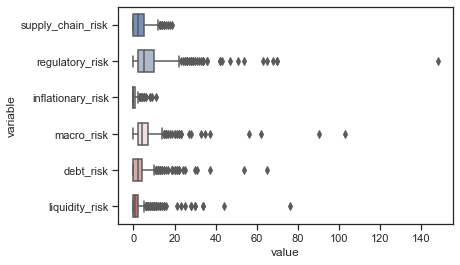

In [12]:
#now with outliers
sns.boxplot(y='variable', x = 'value', data= pd.melt(form10K_df.filter(like='_risk')), width = 0.6, palette='vlag', showfliers=True)
ax.set(xlabel= 'count', ylabel='risk')

## Note on Outlier Frequency
Looks like we have quite a few outliers for each of our distributions. This concerned me a bit at first, but I think that this is likely happening for a few reasons:
- Including the firms which were judged by the entire 10K (which increases the average number of risk factors) could be contributing outliers
- Language within the risk section of 10Ks can vary, as some forms don't explicity mention 'risk' or other related words, which can result in firms that do mention risk related words a lot to appear as a larger outlier 
- Firms with one larger risk will likely have multiple larger risks, both due to the nature of the near_regex function possibly counting multiple risk factors on a single appearence of a risk word, and because firms that face high levels of risk from say, solvency, are probably facing high liquidity risk as well   

In [13]:
#this function retuns the upper limit on outliers, and the number of outliers found for each risk factor
def findRiskOutliers(dataframe):
    risk_outlier_lims = []
    risk_outlier_counts = []
    iqrs = 1.5 * (dataframe.quantile(0.75) - dataframe.quantile(0.25))
    for name, i in zip(risk_names[:6], iqrs):
        #define an outlier as any value more than 1.5 times interquartile range above the mean
        outlier_lim = i + dataframe[name].mean()
        risk_outlier_lims.append(outlier_lim)
        q_str = name + ' > ' + str(outlier_lim)
        num_outliers = form10K_df.query(q_str).count()
        risk_outlier_counts.append(num_outliers)
    return risk_outlier_lims, risk_outlier_counts

form10K_lims, form10K_outlier_counts = findRiskOutliers(form10K_df)
for lim, count, name in zip(form10K_lims, form10K_outlier_counts, risk_names[:6]):
    print(name + ' values above limit of %f: %d' % (lim, count[0]))

supply_chain_risk values above limit of 10.598196: 19
regulatory_risk values above limit of 20.364729: 42
inflationary_risk values above limit of 2.003006: 21
macro_risk values above limit of 13.213427: 33
debt_risk values above limit of 9.585170: 41
liquidity_risk values above limit of 5.494990: 53


,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk
supply_chain_risk,1.000000,0.164300,0.094554,0.132187,0.100698,-0.004822
regulatory_risk,0.164300,1.000000,0.312246,0.512435,0.630586,0.680137
inflationary_risk,0.094554,0.312246,1.000000,0.327007,0.408973,0.255573
macro_risk,0.132187,0.512435,0.327007,1.000000,0.669812,0.681150
debt_risk,0.100698,0.630586,0.408973,0.669812,1.000000,0.639732
liquidity_risk,-0.004822,0.680137,0.255573,0.681150,0.639732,1.000000


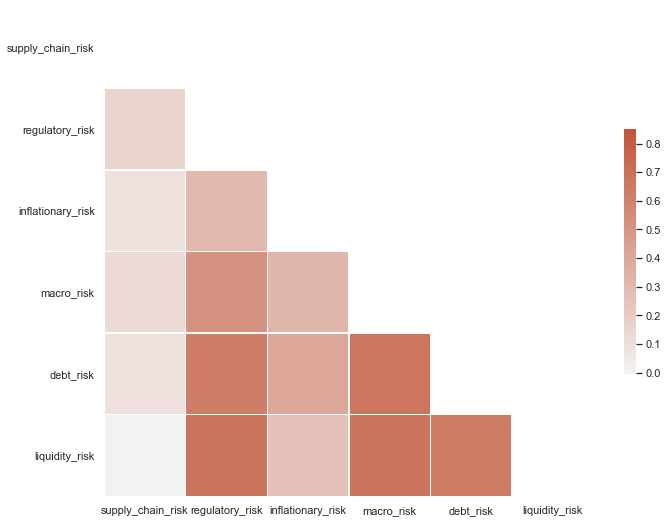

In [14]:
#finally, lets check correlation
sns.set_theme(style="white")
corr = form10K_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.85, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr

In [15]:
#looks pretty good. things like debt and liquidity risk a well correlated, as we would expect to see. The only risk factor which seems unrelated to the rest is supply chain
#now to load the risk and accounting data 
risk_and_data = pd.read_csv('outputs/sp500_accting_plus_textrisks.csv')
if 'Unnamed: 0' in risk_and_data.columns:
    del risk_and_data["Unnamed: 0"]

In [16]:
#now lets get the stock return data
url = 'https://github.com/LeDataSciFi/ledatascifi-2021/blob/main/data/2019-2020-stock_rets%20cleaned.zip?raw=true'

with urlopen(url) as request:
    data = BytesIO(request.read())

with ZipFile(data) as archive:
    with archive.open(archive.namelist()[0]) as stata:
        data = pd.read_stata(stata)
data.to_csv('inputs/stock_returns.csv')
ret_df = pd.read_csv('inputs/stock_returns.csv')
del ret_df['Unnamed: 0']
ret_df

C:\Users\ander\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,permno,date,ticker,comnam,primexch,prc,ret,shrout,vwretd,_merge
0,10026,20191025,JJSF,J & J SNACK FOODS CORP,Q,188.96,-0.005997,18895.0,0.004069,matched (3)
1,10026,20200311,JJSF,J & J SNACK FOODS CORP,Q,146.20,-0.066232,18919.0,-0.049958,matched (3)
2,10026,20200108,JJSF,J & J SNACK FOODS CORP,Q,182.04,-0.005409,18900.0,0.004028,matched (3)
3,10026,20200413,JJSF,J & J SNACK FOODS CORP,Q,121.93,-0.045334,18888.0,-0.010146,matched (3)
4,10026,20200602,JJSF,J & J SNACK FOODS CORP,Q,128.74,-0.018076,18888.0,0.008413,matched (3)
...,...,...,...,...,...,...,...,...,...,...
724220,93436,20190425,TSLA,TESLA INC,Q,247.63,-0.042643,173721.0,-0.001464,matched (3)
724221,93436,20190619,TSLA,TESLA INC,Q,226.43,0.00752,177270.0,0.003742,matched (3)
724222,93436,20190927,TSLA,TESLA INC,Q,242.13,-0.001773,179127.0,-0.005689,matched (3)
724223,93436,20191219,TSLA,TESLA INC,Q,404.04,0.027699,180245.0,0.004193,matched (3)


In [17]:
#there's a couple of bad observations in the ret column, clean it up and create cross returns 
ret_df = ret_df.rename(columns={'ticker' : 'tic'})
ret_df['ret'] = ret_df['ret'].apply(pd.to_numeric, errors='coerce')
ret_df = ret_df.assign(gross_ret = 1 + ret_df['ret'])

In [18]:
rets_and_10k = pd.merge(left=form10K_df, right=ret_df, how='left', validate='one_to_many', on = 'tic')
#this chunk adds a column of dates that are usable by datetime
rets_and_10k['date'] = (rets_and_10k['date'].astype(str))
datetimes = []
c = 0
for index, row in rets_and_10k.iterrows():
    date_str = row['date']
    date_str_cut = date_str[:-2]
    #don't need any dates in 2019 for analysis, this effectively removes them from being included in week counts
    if date_str_cut[:4] == '2019':
        datetimes.append('-1')
        continue
    datetime_str = date_str_cut[:4] + '-' + date_str_cut[4:6] + '-' + date_str_cut[6:]
    datetimes.append(datetime_str)

rets_and_10k['datetime'] = datetimes
#little clunky, but it works

In [19]:
#add the weeks column 
rets_and_10k['datetime'] = pd.to_datetime(rets_and_10k['datetime'], errors='coerce')
rets_and_10k = rets_and_10k.assign(week = rets_and_10k['datetime'].dt.isocalendar().week)
rets_and_10k

,tic,url,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk,doctype,permno,...,comnam,primexch,prc,ret,shrout,vwretd,_merge,gross_ret,datetime,week
0,MMM,https://www.sec.gov/Archives/edgar/data/66740/...,3.0,6.0,1.0,4.0,1.0,0.0,Risk Section,22592.0,...,3M CO,N,153.30,0.064140,575600.0,0.044398,matched (3),1.064140,2020-03-10,11
1,MMM,https://www.sec.gov/Archives/edgar/data/66740/...,3.0,6.0,1.0,4.0,1.0,0.0,Risk Section,22592.0,...,3M CO,N,170.58,0.014874,575279.0,0.002394,matched (3),1.014874,NaT,<NA>
2,MMM,https://www.sec.gov/Archives/edgar/data/66740/...,3.0,6.0,1.0,4.0,1.0,0.0,Risk Section,22592.0,...,3M CO,N,165.17,-0.018423,575051.0,-0.005643,matched (3),0.981577,NaT,<NA>
3,MMM,https://www.sec.gov/Archives/edgar/data/66740/...,3.0,6.0,1.0,4.0,1.0,0.0,Risk Section,22592.0,...,3M CO,N,146.40,-0.009338,575261.0,-0.010146,matched (3),0.990662,2020-04-13,16
4,MMM,https://www.sec.gov/Archives/edgar/data/66740/...,3.0,6.0,1.0,4.0,1.0,0.0,Risk Section,22592.0,...,3M CO,N,179.78,-0.008767,575051.0,0.001938,matched (3),0.991233,2020-01-15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184078,ZTS,https://www.sec.gov/Archives/edgar/data/155528...,6.0,19.0,0.0,15.0,3.0,4.0,Risk Section,13788.0,...,ZOETIS INC,N,85.90,-0.003827,480451.0,0.004474,matched (3),0.996173,NaT,<NA>
184079,ZTS,https://www.sec.gov/Archives/edgar/data/155528...,6.0,19.0,0.0,15.0,3.0,4.0,Risk Section,13788.0,...,ZOETIS INC,N,120.28,-0.076687,474934.0,-0.096841,matched (3),0.923313,2020-03-12,11
184080,ZTS,https://www.sec.gov/Archives/edgar/data/155528...,6.0,19.0,0.0,15.0,3.0,4.0,Risk Section,13788.0,...,ZOETIS INC,N,127.04,0.004904,477558.0,-0.007200,matched (3),1.004904,NaT,<NA>
184081,ZTS,https://www.sec.gov/Archives/edgar/data/155528...,6.0,19.0,0.0,15.0,3.0,4.0,Risk Section,13788.0,...,ZOETIS INC,N,100.12,0.011007,478772.0,0.000550,matched (3),1.011007,NaT,<NA>


In [20]:
#03/09-03/13: week 11
#02/23-3/23: collapse period
#3/24: stimmy day 

In [21]:
#now to get the returns of each firm over the week 
collapse_week_df = rets_and_10k.query('week in [11]')
collapse_week_ret = (collapse_week_df
              .groupby(['tic'])
              ['gross_ret'].prod() - 1     
)
collapse_week_df = collapse_week_ret.to_frame()
collapse_week_df = collapse_week_df.rename(columns= {'gross_ret' : 'collapse_w_ret'})
#this gets all the returns for the day of simulus announcement, no need to calculate gross returns since it's a single day 
stimmy_df = rets_and_10k.query('date in ["20200324.0"]')

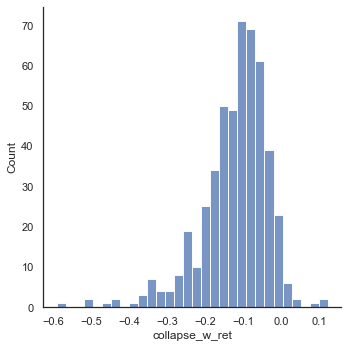

In [22]:
#hows the distribution of returns over the week?
sns.displot(collapse_week_df['collapse_w_ret'])

In [23]:
#lots of red, looks right to me 
#who had it the best/worst? the average?
print(collapse_week_ret.nlargest(1))
print(collapse_week_ret.nsmallest(1))
print('Average: %f' % collapse_week_ret.mean())

tic
COG    0.122175
Name: gross_ret, dtype: float64
tic
NCLH   -0.590406
Name: gross_ret, dtype: float64
Average: -0.121634


Average: 0.115711


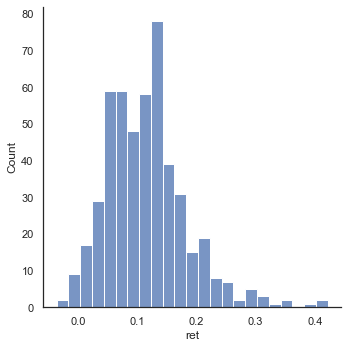

In [24]:
#norwegian cruise lines with a near 60% weekly loss, makes sense
#lets see if the simulus worked
sns.displot(stimmy_df['ret'])
print('Average: %f' % stimmy_df['ret'].mean())

In [25]:
#looks like it!
#now to add these into the dataframe
risk_data_ret = pd.merge(left=risk_and_data, right = collapse_week_df, on='tic', how='left', validate='one_to_one')
risk_data_ret

,tic,url,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk,doctype,gvkey,...,ppe_a,cash_a,xrd_a,dltt_a,invopps_FG09,sales_g,dv_a,short_debt,_merge,collapse_w_ret
0,MMM,https://www.sec.gov/Archives/edgar/data/66740/...,3.0,6.0,1.0,4.0,1.0,0.0,Risk Section,7435.0,...,0.228196,0.065407,0.042791,0.408339,2.749554,NaN,0.074252,0.143810,both,-0.077905
1,ABT,https://www.sec.gov/Archives/edgar/data/1800/0...,4.0,7.0,2.0,5.0,3.0,1.0,Risk Section,1078.0,...,0.132161,0.060984,0.035942,0.256544,2.520681,NaN,0.033438,0.088120,both,-0.001101
2,ABBV,https://www.sec.gov/Archives/edgar/data/155115...,2.0,7.0,2.0,3.0,4.0,0.0,Risk Section,16101.0,...,0.037098,0.448005,0.076216,0.709488,2.211589,NaN,0.071436,0.057566,both,-0.038844
3,ABMD,https://www.sec.gov/Archives/edgar/data/815094...,3.0,11.0,0.0,7.0,1.0,2.0,Risk Section,13619.0,...,0.137531,0.466354,0.088683,0.000000,12.164233,NaN,0.000000,NaN,both,-0.090781
4,ACN,https://www.sec.gov/Archives/edgar/data/146737...,4.0,10.0,1.0,6.0,2.0,0.0,Risk Section,143357.0,...,0.046699,0.205780,0.026846,0.000545,4.241083,NaN,0.062583,0.282946,both,-0.068476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,YUM,https://www.sec.gov/Archives/edgar/data/104106...,4.0,6.0,2.0,6.0,3.0,2.0,Risk Section,65417.0,...,0.346396,0.142038,0.000000,1.071959,8.046718,NaN,0.097687,0.044192,both,-0.122372
495,ZBRA,https://www.sec.gov/Archives/edgar/data/877212...,8.0,3.0,0.0,7.0,3.0,0.0,Risk Section,24405.0,...,0.077691,0.006368,0.094884,0.250478,3.225952,NaN,0.000000,0.160740,both,-0.092335
496,ZBH,https://www.sec.gov/Archives/edgar/data/113686...,3.0,4.0,0.0,2.0,1.0,0.0,Risk Section,144559.0,...,0.095139,0.025078,0.021081,0.281545,1.556915,NaN,0.007983,0.184000,both,-0.211926
497,ZION,https://www.sec.gov/Archives/edgar/data/109380...,0.0,0.0,0.0,0.0,0.0,0.0,Risk Section,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,-0.166100


<AxesSubplot:xlabel='supply_chain_risk', ylabel='collapse_w_ret'>

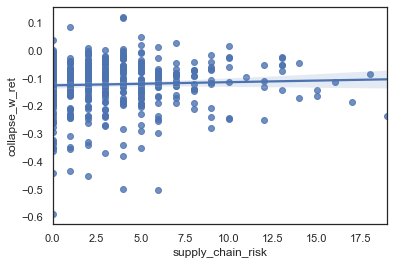

In [26]:
#now that we have out completed dataframe, lets see the correlation between weekly returns and the perceived risk in each category 
sns.regplot(x= risk_data_ret[risk_names[0]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret)

<AxesSubplot:xlabel='regulatory_risk', ylabel='collapse_w_ret'>

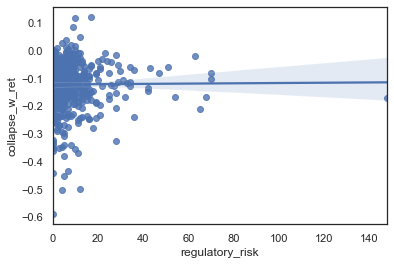

In [27]:
sns.regplot(x= risk_data_ret[risk_names[1]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret)

<AxesSubplot:xlabel='inflationary_risk', ylabel='collapse_w_ret'>

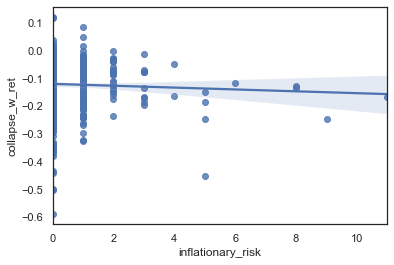

In [28]:
sns.regplot(x= risk_data_ret[risk_names[2]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret)

<AxesSubplot:xlabel='macro_risk', ylabel='collapse_w_ret'>

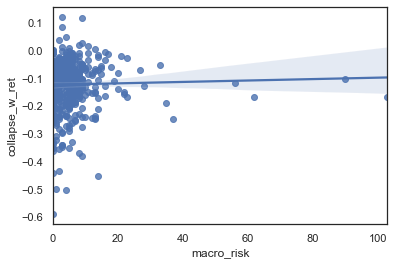

In [29]:
sns.regplot(x= risk_data_ret[risk_names[3]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret)

<AxesSubplot:xlabel='debt_risk', ylabel='collapse_w_ret'>

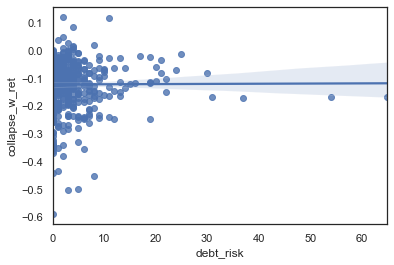

In [30]:
sns.regplot(x= risk_data_ret[risk_names[4]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret)

<AxesSubplot:xlabel='liquidity_risk', ylabel='collapse_w_ret'>

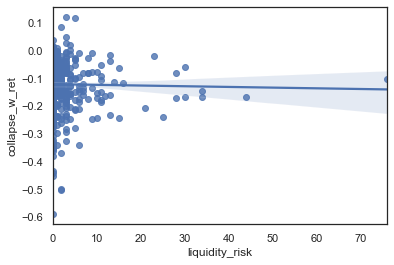

In [31]:
sns.regplot(x= risk_data_ret[risk_names[5]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret)

In [32]:
#a lot are pretty flat, suggesting low (near-zero) correlation
#lets see
for name in risk_names:
    name.replace(' ', '_')
collapse_corr = (pd.merge(left=form10K_df, right=collapse_week_df, how='left', on='tic')
                 .corr()
                 .drop([name for name in risk_names])
                 .drop(columns=['collapse_w_ret'])
)
collapse_corr

,supply_chain_risk,regulatory_risk,inflationary_risk,macro_risk,debt_risk,liquidity_risk
collapse_w_ret,0.044363,0.007019,-0.044031,0.024516,0.004338,-0.016708


In [33]:
#not much of a correlation
#lets try it withuot the outliers 
c = 0
for i, name in zip(form10K_lims, risk_names[:6]):
    for index, row in risk_data_ret.iterrows():
        if row[name] > i:
            #make the value null if outlier
            risk_data_ret.loc[index, name] = np.nan

<AxesSubplot:xlabel='supply_chain_risk', ylabel='collapse_w_ret'>

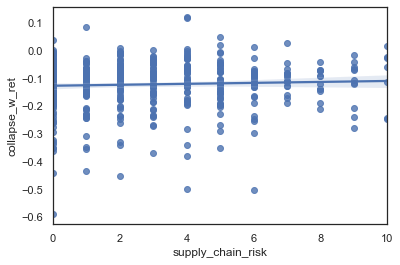

In [34]:
sns.regplot(x= risk_data_ret[risk_names[0]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret.notnull())

<AxesSubplot:xlabel='regulatory_risk', ylabel='collapse_w_ret'>

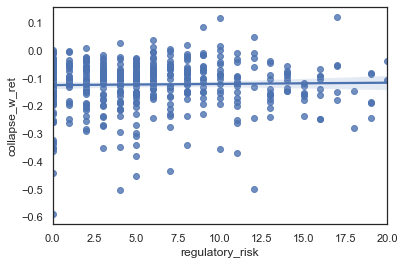

In [35]:
sns.regplot(x= risk_data_ret[risk_names[1]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret.notnull())

<AxesSubplot:xlabel='inflationary_risk', ylabel='collapse_w_ret'>

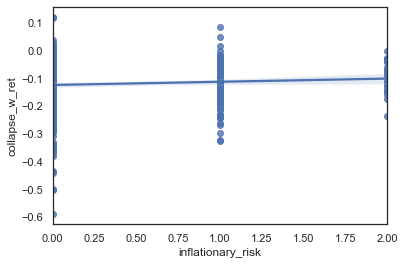

In [36]:
sns.regplot(x= risk_data_ret[risk_names[2]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret.notnull())

<AxesSubplot:xlabel='macro_risk', ylabel='collapse_w_ret'>

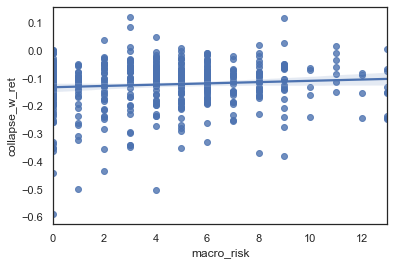

In [37]:
sns.regplot(x= risk_data_ret[risk_names[3]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret.notnull())

<AxesSubplot:xlabel='debt_risk', ylabel='collapse_w_ret'>

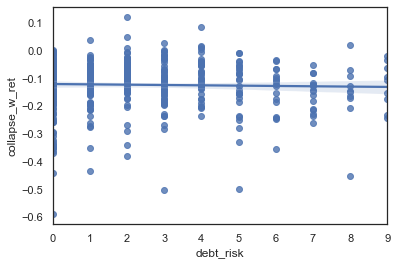

In [38]:
sns.regplot(x= risk_data_ret[risk_names[4]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret.notnull())

<AxesSubplot:xlabel='liquidity_risk', ylabel='collapse_w_ret'>

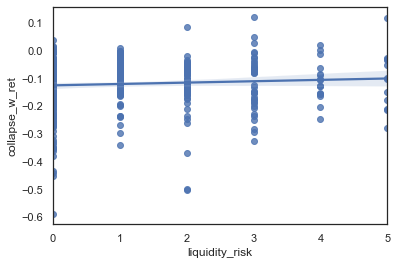

In [39]:
sns.regplot(x= risk_data_ret[risk_names[5]], y= risk_data_ret['collapse_w_ret'], data=risk_data_ret.notnull())

# Note on Correlation
Disappointingly, the correlation does not end up being very negative between each risk factor and the returns over the collapse week. This is likely due to the fact that automating a system to scan for risks through a qualitative document is a difficult task, and perhaps my approach was too slimplistic to accurately capture the true risks faced by each firm. On the other hand, its likely that this period of panic selling treated firms largely the same, and that all firms experienced large sell-offs regardless of the serverity of type of risks they faced. Following this, rises in retail investing have in turn caused the number of people who own ETFs and mutual funds to increase. These relatively inexperienced traders, when faced with massive short term losses, could have sold off their positions in hopes to avoid sustaining more losses. And, since most own large ETFs which track stocks across multiple sectors, resulted in decreased demand - and prices - across the board for all firms.  

Despite the generally low correlation between all risk factors and the returns seen over the week from 3/09/2020-03/13/2020, the risk factor with the most negative correlation was inflation risk. This is unsuprising, as periods of economic depression see expansionary monetary and fiscal policies, which include dampening rates and injecting the economy with more cash through treasury buybacks and money printing. So, firms which face risks related to periods of higher inflation were likely set up to suffer more as the economy attempted to get back onto its feet. 